# Beam Search

El algoritmo de beam search (o búsqueda por haz) es un algoritmo de búsqueda que limita las acciones, los hijos que puede tener un nodo en el árbol de búsqueda, a un valor constante $k$. De esta forma, en cada paso selecciona únicamente las $k$ mejores acciones a ejecutar de acuerdo a una función de prioridad, ignorando las otras.

Definimos aquí el algoritmo aplicado al problema del laberinto.

### Construcción del problema

El problema es idéntico al que hemos usado para los algoritmos anteriores. Se parte de un punto incial (marcado con 'o') y se busca llegar al punto final (marcado con 'x').

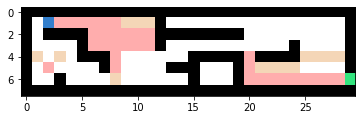

In [1]:
import numpy as np
from maze_simulator import TrafficMaze

mapa = """
##############################
# o------...#                #
# ####------########         #
#    #------#           #    #
#. . ###-      #####-####....#
# -    #-    ###   #-....    #
#  #    .      #   #---------x
##############################
"""

ent = TrafficMaze(mapa)
ent.draw()

## Función heurística

Usamos una función de probabilidad basada en métricas, lo que define una probabilidad radial. Los elementos más cercanos a la meta son los elementos más probables. 

$$p(x;y) = \exp\{-d(x,y)\}$$

$d$ es una métrica y $y$ será el nodo meta. Es decir, la probabilidad de un elemento se basará en su distancia al nodo meta. En este caso, usamos una métrica euclideana para tomar la distancia. Así, entre más cerca nos encontremos de la meta, el valor de la heurística será mayor.

In [2]:
def h(state, goal):
    """Heurísitca probabilística"""
    x1,y1 = state
    x2,y2 = goal
    #Obtiene distancia euclideana
    dist = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    #Obtiene probabilidad
    probability = np.exp(-dist)
    return probability

### Pila de prioridad

La pila de prioridad que tomamos aquí es similar a las anteriores, pero en este caso la prioridad estará determinada por un valor de probabilidad definida como anteriormente; esto tiene diferentes consecuencias, la más simple es que en lugar de minimizar el valor, se busca mazimizar, aunque es claro que ambos casos son equivalentes pues basta usar el signo negativo $-$ o bien usar el inverso de la probabilidad $\frac{1}{p}$ para tener un argumento que se minimice.

El punto esencial aquí es que en cada paso la pila sólo puede contener a lo más $k$ elementos. Para esto definimos un parámetro $k$ y modificamos la función de <tt>push</tt> que antes de introducir un nuevo elemento revisa si este tiene mayor prioridad que otros en la pila. En cada caso, se quedará con los $k$ elementos con mayor prioridad.

In [3]:
class PriorityQueue(object):
    """Clase de una cola de prioridad en los problemas de búsqueda, limitando el tamaño de pila"""
    def __init__(self,h=lambda x: 1,k=3):
        self.queue = []
        self.h = h
        self.size = k
  
    def __str__(self):
        return ' '.join([str(q) for q in self.queue])
  
    def isEmpty(self):
        """Revisa si la pila está vacía"""
        return self.queue == []
  
    def push(self, element):
        """Introduce un elemento, pero sólo puede contener a lo más k elementos"""
        if len(self.queue) >= self.size:
            #Si se sobrepasa el limite de elementos
            for item in self.queue:
                #Revisa cual es el de menor prioridad
                if item.f < element.f:
                    #y toma el de mayor prioridad
                    self.queue.remove(item)
                    self.queue.append(element)
        else:
            self.queue.append(element)
  
    def pop(self):
        """Saca el elemento con mayor prioridad"""
        argmax = np.argmax([element.f for element in self.queue])
        item = self.queue[argmax]
        del self.queue[argmax]
    
        return item
    
    def top(self):
        """Muestra el elemento en el tope de la pila"""
        argmax = np.argmax([element.f for element in self.queue])
        item = self.queue[argmax]
        
        return item

#### Nodos y expansión de nodos

Los nodos tendrán los mimso elementos con los que hemos construido otros algoritmos. La diferencia aquí radicará en su expansión. Puesto que estamos considerando una probabilidad como función $f$, en lugar de sumar los valores de $f$, asumimos independencia y multiplicamos los productos, esto es, buscamos:

$$\arg\max f(n_t) = \arg\max \prod_{i=0}^t p(n_i; n_{goal})$$

Pero es claro que esto es equivalente a:

$$\arg\min f'(n_t) = \arg\min \sum_{i=0}^t -\log\big( p(n_i; n_{goal}) \big)$$

Donde la función de prioridad respondería a $-\log\big( p(n_i; n_{goal}) \big)$, en lugar de sólo a la probabilidad. De esta forma, tendríamos mayor similitud con los anteriores algoritmos.

In [4]:
class Node(object):
    """Clase para crear nodos con sus atributos."""
    def __init__(self):
        self.state = None
        self.parent = None 
        self.action = None
        self.cost = 0
        self.f = 1
        
    def __str__(self):
        return str(self.state)
    
def expand(problem, node):
    """Expansión de nodos"""
    s = node.state
    for action in problem.actions(s):
        new_s = problem.result(s, action)
        new_node = Node()
        new_node.state,new_node.parent,new_node.action,new_node.cost = new_s,node,action,node.cost+problem.cost(s,action,new_s)
        #Prioridad del nodo
        new_node.f = node.f*h(new_s, problem.goal)

        yield new_node

## Algoritmo Beam Search

La implementación del algoritmo Beam Search se puede resumir en los siguientes pasos:

1. Seleccionar los $k$ nodos de menor costo dado el inicial, y guardar sólo esos nodos.
2. En cada nueva iteración se expande sólo los $k$ nodos obtenidos en la iteración anterior. Los otros nodos se olvidan.
3. Se conservan sólo los $k$ nodos con menor costo en cada iteración.
4. Se repite hasta alcanzar un estado meta.

In [5]:
def BeamSearch(problem, max_size=3):
    """Algoritmo de búsqueda por haz (Beam Search)"""
    #Almacenamiento de nodos
    nodes = []
    #Nodo inicial
    node = Node()
    node.state = problem.initial
    #Frontera con cola de prioridad con límite
    frontier = PriorityQueue(k=max_size)
    frontier.push(node)
    #Nodos alcanzados
    reached = {problem.initial:node}

    #Mientras la frontera no esté vacía
    while frontier.isEmpty() == False:
        print('Tamaño de frontera: {}'.format(len(frontier.queue))) #Imprime tamaño de frontera
        #Pop en frontera
        node = frontier.pop()
        #Guarda el nodo en la lista
        nodes.append(node)
        #Actualiza el estado del problema
        problem.state = node.state

        #Si llega a un estado final se detiene 
        #y regresa el camino de nodos
        if problem.state == problem.goal:
            return nodes

        #Expande el nodo actual
        expantion = expand(problem, node)
        for child in expantion:
            #print(child.f)
            #Guarda estado de los hijos
            state = child.state
            #Guarda los hijos no alcanzados o que tengan menor costo
            if state not in reached.keys() or child.f < reached[state].f:
                reached[state] = child
                frontier.push(child)

    #Si no logra llegar a un nodo final
    #El algoritmo regresa mensaje de error
    return "No se ha logrado llegar a un estado final."

#### Aplicación del algortimo

Finalmente podemos aplicar el algoritmo al problema del laberinto que hemos definido y observar los resultados obtenidos en este. También podremos ver que el tamaó de la frontera siempre será de máximo 3 elementos, los 3 elementos que cuenten con mayor prioridad.

In [6]:
tree = BeamSearch(ent)

Tamaño de frontera: 1
Tamaño de frontera: 2
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de frontera: 3
Tamaño de 

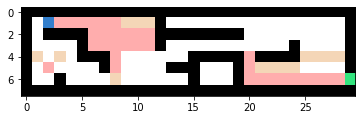

Solución


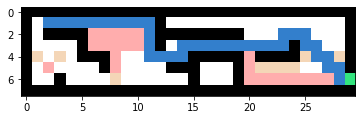

Costo total: 58


In [7]:
def get_path(search_tree, root):
    """Recupera la solución."""
    leaf = search_tree[::-1][0]
    parent = leaf.parent
    path = [leaf, parent]
    while parent.state != root:
        parent = parent.parent
        path.append(parent)
        
    return path[::-1]

ent.draw()
#Visualiza la solución
prev_s = ent.initial
for n in get_path(tree, ent.initial):
    ent.move(prev_s, n.state)
    prev_s = n.state

print('Solución')
ent.draw()
print('Costo total: {}'.format(tree[-1].cost))